# Candlestick Formation
In this notebook, we will take the data we have farmed via Bitfinex API and will be converting our data into candle-stick formation images. 

The very first part of this notebook will be to test the functionality with a small subset of the data. 

Then we will form both a window & label algorithm which will be used to create window images labelled for our classification task. 

Each window will be composed of 15, 30 min intervals which will be labeled according to the 20th (5 points preceeding our window) opening price. 

That is: 

```python
if open_of_20th > close_of_15th_by_3_percent:
    label = 'buy'
elif open_of_20th < close_of_15th:
    label = 'sell'
else:
    label = 'hold'
```

Given the nature of BTC/USD and most cryptocurrencies, labeling with aggresive moves may be a good strategy.

In fact, our labeling algorithm will greatly impact the overall trading strategy, thus we may revisit this in the future for optimization. 

## 30min DATA

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import gc

from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from time import sleep
import multiprocessing as mp

In [2]:
# Loading our data
file = './post_processing/btcusd_ohlc_2017_2019.csv'

headers = ['date', 'open', 'close', 'high', 'low', 'volume']
my_dtypes = {
    'date': 'str',
    'open': 'float',
    'close': 'float',
    'high': 'float',
    'low': 'float',
    'volume': 'float'
}

my_parse_dates = ['date']

df = pd.read_csv(file, header=0, names=headers, dtype=my_dtypes, parse_dates=my_parse_dates)

# Re-arranging columns for OHLC
df = df[['date', 'open', 'high', 'low', 'close', 'volume']]

In [3]:
df.head()

,date,open,high,low,close,volume
0,2017-01-01 05:00:00,962.98,963.00,962.11,962.98,29.466950
1,2017-01-01 05:30:00,962.90,965.20,962.56,964.88,61.575102
2,2017-01-01 06:00:00,963.90,964.95,962.72,962.83,27.068546
3,2017-01-01 06:30:00,963.49,967.45,963.36,967.45,78.595934
4,2017-01-01 07:00:00,966.48,967.41,966.48,966.67,21.279508


In [4]:
df.tail()

,date,open,high,low,close,volume
40779,2019-05-01 02:00:00,5619.370256,5643.0,5619.258079,5632.20000,289.576023
40780,2019-05-01 02:30:00,5632.300000,5632.3,5620.600000,5620.60000,84.910372
40781,2019-05-01 03:00:00,5622.300000,5629.7,5615.100000,5619.30000,50.869072
40782,2019-05-01 03:30:00,5619.300000,5623.0,5591.900000,5619.10000,229.368454
40783,2019-05-01 04:00:00,5619.100000,5625.1,5615.700000,5625.08833,66.739223


In [5]:
# setting date to datetime
df['date'] = pd.to_datetime(df['date'])

In [6]:
# # Setting our date as the index to extract data from 2017-2019 only
# df.set_index('date', inplace=True)

In [7]:
df.head()

,date,open,high,low,close,volume
0,2017-01-01 05:00:00,962.98,963.00,962.11,962.98,29.466950
1,2017-01-01 05:30:00,962.90,965.20,962.56,964.88,61.575102
2,2017-01-01 06:00:00,963.90,964.95,962.72,962.83,27.068546
3,2017-01-01 06:30:00,963.49,967.45,963.36,967.45,78.595934
4,2017-01-01 07:00:00,966.48,967.41,966.48,966.67,21.279508


In [8]:
# our mask filter
mask = (df['date'] > "2017-1-01") & (df['date'] < '2019-1-01')

In [9]:
# filtering
df = df.loc[mask]

In [10]:
df.head(3)

,date,open,high,low,close,volume
0,2017-01-01 05:00:00,962.98,963.00,962.11,962.98,29.466950
1,2017-01-01 05:30:00,962.90,965.20,962.56,964.88,61.575102
2,2017-01-01 06:00:00,963.90,964.95,962.72,962.83,27.068546


In [11]:
df.tail(3)

,date,open,high,low,close,volume
35023,2018-12-31 22:30:00,3812.3,3833.0,3812.200000,3829.7,218.647193
35024,2018-12-31 23:00:00,3829.2,3839.9,3822.400000,3834.1,155.449818
35025,2018-12-31 23:30:00,3834.1,3834.1,3819.904507,3830.5,84.687002


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35026 entries, 0 to 35025
Data columns (total 6 columns):
date      35026 non-null datetime64[ns]
open      35026 non-null float64
high      35026 non-null float64
low       35026 non-null float64
close     35026 non-null float64
volume    35026 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.9 MB


In [13]:
batch_size = len(df) / 2
batch_size

17513.0

In [14]:
len(df)

35026

In [15]:
# Splitting our DF into two batches
df1 = df.iloc[:int(batch_size)].copy()
df2 = df.iloc[int(batch_size):].copy()

In [16]:
df1.head(2)

,date,open,high,low,close,volume
0,2017-01-01 05:00:00,962.98,963.0,962.11,962.98,29.466950
1,2017-01-01 05:30:00,962.90,965.2,962.56,964.88,61.575102


In [17]:
df1.tail(2)

,date,open,high,low,close,volume
17511,2018-01-01 01:00:00,13621.0,13655.0,13505.0,13610.0,311.082200
17512,2018-01-01 01:30:00,13610.0,13631.0,13251.0,13281.0,1099.627958


In [18]:
df2.head(2)

,date,open,high,low,close,volume
17513,2018-01-01 02:00:00,13280.0,13440.0,13251.0,13273.0,704.089059
17514,2018-01-01 02:30:00,13260.0,13398.0,13214.0,13362.0,523.346695


In [19]:
df2.tail(2)

,date,open,high,low,close,volume
35024,2018-12-31 23:00:00,3829.2,3839.9,3822.400000,3834.1,155.449818
35025,2018-12-31 23:30:00,3834.1,3834.1,3819.904507,3830.5,84.687002


## Testing our plot

In [20]:
# Creating test df window - to test our candlestick formation
window_one = df.iloc[:15].copy()

In [21]:
# converting dates into floats for ohcl framework
window_one['date'] = [mdates.date2num(d) for d in window_one['date']]

In [22]:
window_one.head()

,date,open,high,low,close,volume
0,736330.208333,962.98,963.00,962.11,962.98,29.466950
1,736330.229167,962.90,965.20,962.56,964.88,61.575102
2,736330.250000,963.90,964.95,962.72,962.83,27.068546
3,736330.270833,963.49,967.45,963.36,967.45,78.595934
4,736330.291667,966.48,967.41,966.48,966.67,21.279508


In [23]:
# re-arrange and grab values
quotes = [tuple(x) for x in window_one[['date', 'open', 'high', 'low', 'close']].values]

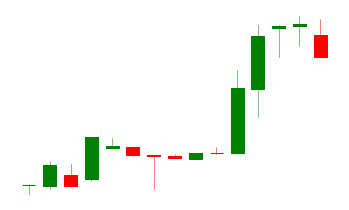

In [25]:
# Test plot
fig, ax = plt.subplots()
candlestick_ohlc(ax, quotes, width=0.013, colorup='g', colordown='r')

# hiding axis
plt.yticks([])
plt.xticks([])
plt.axis('off')

plt.gcf().autofmt_xdate()

# Labeling & Creating Images

In [20]:
# converting our dates into floats for OHLC
df1['date'] = [mdates.date2num(d) for d in df1['date']]
df2['date'] = [mdates.date2num(d) for d in df2['date']]

In [21]:
gc.collect()

0

### Batch One

In [29]:
# FUNCTIONS

def save_image(df, path):
    """
    df: Dataframe to create images
    path: path in which we will save the images
    """
    gc.disable()
    
#     # instantiating 
#     start_index = 0
#     end_index = 15
#     label_index = 20
#     img_index = 1

    # instantiating 
    start_index = 0
    end_index = 15   # 24 hour window
    label_index = 21 # Target 3 hours
    img_index = 1
    
    for i in tqdm(range(len(df))):
        
        try:

            # Creating our window
            window_df = df.iloc[start_index:end_index]
            
            # grabbing close of 15th day
            day_10_close = window_df.iloc[-1]['close']
            
            # Calculating 3% increase
            three_percent_increase = day_10_close + (day_10_close * 0.03)
            
            # Calculating 1% decrease
            one_percent_decrease = day_10_close - (day_10_close * 0.01)
            
            # Converting window_df into quotes for OHCL
            quotes = [tuple(x) for x in window_df[['date','open','high','low','close']].values]
            
            # Plot candlestick.
            fig, ax = plt.subplots()
            candlestick_ohlc(ax, quotes, width=0.013, colorup='g', colordown='r')

            # hiding x, y values
            plt.yticks([])
            plt.xticks([])
            plt.axis('off')

            plt.gcf().autofmt_xdate()
            
            # Labelling 
            
            # BUY
            if df.iloc[label_index]['open'] >= three_percent_increase:
                
                # Saving buy
                label = 'Buy'
                plt.savefig(f'{path}/{img_index}.{label}.png', dpi=100)
                
                # Clearing memory
                plt.close('all')
                plt.clf()
                plt.cla()
                fig.clf()

                # Increase image index
                img_index += 1
            
            # SELL
            elif df.iloc[label_index]['open'] <= one_percent_decrease:
                
                # Sell
                label = 'Sell'
                plt.savefig(f'{path}/{img_index}.{label}.png', dpi=100)
                
                # Clearing memory
                plt.close('all')
                plt.clf()
                plt.cla()
                fig.clf()

                # Increase image index
                img_index += 1
                
            # HOLD
            else:
                
                # Hold
                label = 'Hold'
                plt.savefig(f'{path}/{img_index}.{label}.png', dpi=100)
                
                
                # Clearing memory
                plt.close('all')
                plt.clf()
                plt.cla()
                fig.clf()

                # Increase index
                img_index += 1
                
            # Coutning up index
            start_index += 1
            end_index += 1
            label_index += 1
            
            if i % 1000 == 0:
                sleep(5)
                gc.collect()
                sleep(5)

            
        except Exception:
            pass
        
        
    # finished
    print('Finished')
    

# Worker Function
def worker(df_):
    save_path = f'{os.curdir}/model_data/images_unscattered'
    save_image(df_, save_path)

100%|█████████▉| 17509/17513 [43:54<00:00, 18.79it/s]   /opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
100%|██████████| 17513/17513 [43:54<00:00,  6.65it/s]

Finished


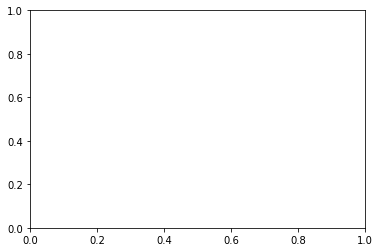

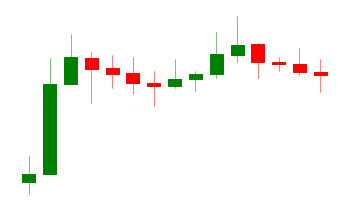

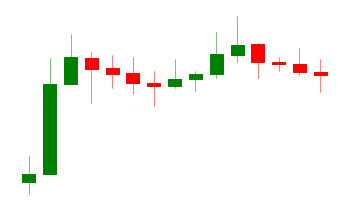

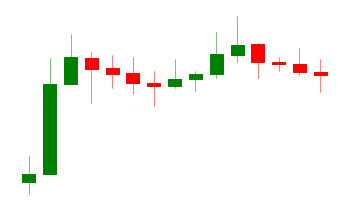

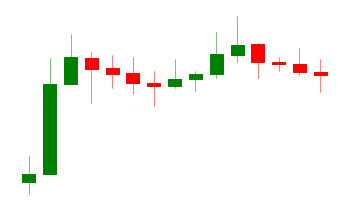

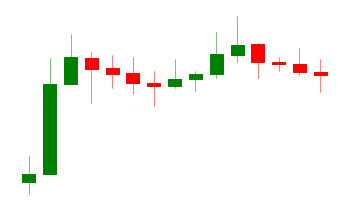

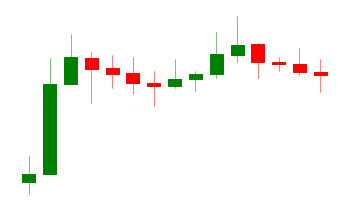

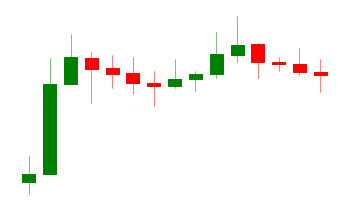

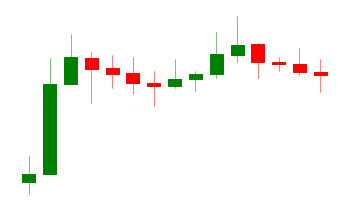

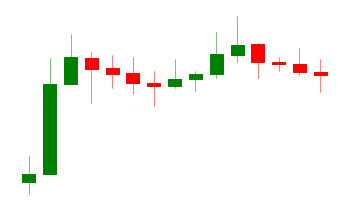

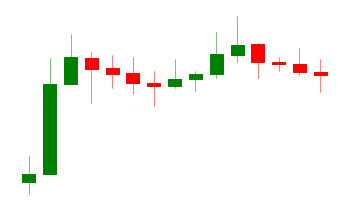

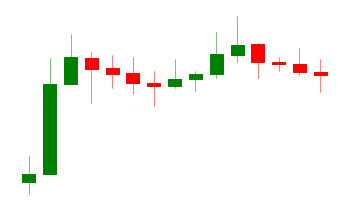

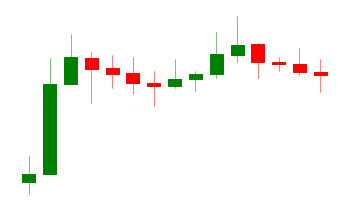

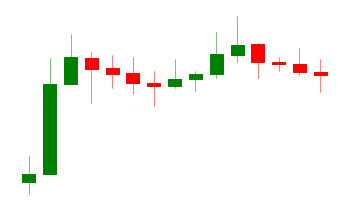

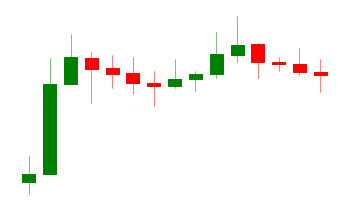

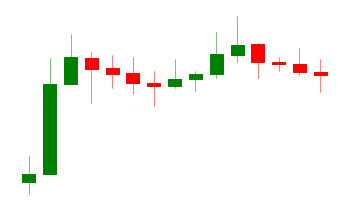

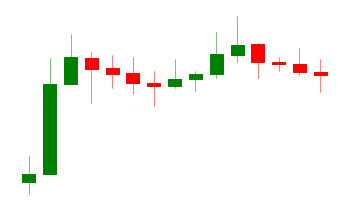

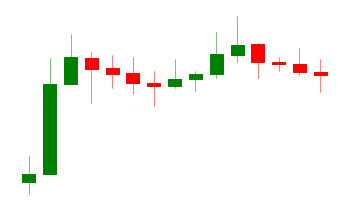

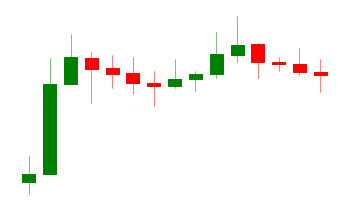

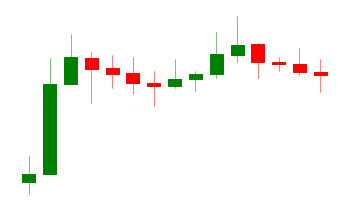

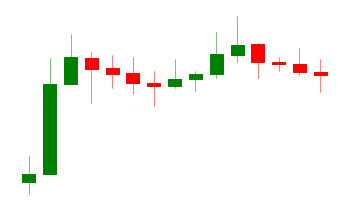

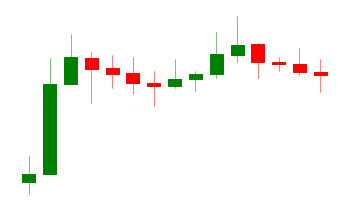

In [30]:
# Saving images using multi-processing
if __name__ == "__main__":
    proc = mp.Process(target=worker(df1)) # our worker function with our df
    proc.deamon = True
    proc.start()
    proc.join()

### Batch Two

In [22]:
# FUNCTIONS - BATCH TWO

def save_image(df, path):
    """
    df: Dataframe to create images
    path: path in which we will save the images
    """
    gc.disable()
    
#     # instantiating 
#     start_index = 0
#     end_index = 15
#     label_index = 20
#     img_index = 1

    # instantiating 
    start_index = 0
    end_index = 15   # 24 hour window
    label_index = 21 # Target 3 hours
    img_index = len(df) + 1 # starting at the end
    
    for i in tqdm(range(len(df))):
        
        try:

            # Creating our window
            window_df = df.iloc[start_index:end_index]
            
            # grabbing close of 15th day
            day_10_close = window_df.iloc[-1]['close']
            
            # Calculating 3% increase
            three_percent_increase = day_10_close + (day_10_close * 0.03)
            
            # Calculating 1% decrease
            one_percent_decrease = day_10_close - (day_10_close * 0.01)
            
            # Converting window_df into quotes for OHCL
            quotes = [tuple(x) for x in window_df[['date','open','high','low','close']].values]
            
            # Plot candlestick.
            fig, ax = plt.subplots()
            candlestick_ohlc(ax, quotes, width=0.013, colorup='g', colordown='r')

            # hiding x, y values
            plt.yticks([])
            plt.xticks([])
            plt.axis('off')

            plt.gcf().autofmt_xdate()
            
            # Labelling 
            
            # BUY
            if df.iloc[label_index]['open'] >= three_percent_increase:
                
                # Saving buy
                label = 'Buy'
                plt.savefig(f'{path}/{img_index}.{label}.png', dpi=100)
                
                # Clearing memory
                plt.close('all')
                plt.clf()
                plt.cla()
                fig.clf()

                # Increase image index
                img_index += 1
            
            # SELL
            elif df.iloc[label_index]['open'] <= one_percent_decrease:
                
                # Sell
                label = 'Sell'
                plt.savefig(f'{path}/{img_index}.{label}.png', dpi=100)
                
                # Clearing memory
                plt.close('all')
                plt.clf()
                plt.cla()
                fig.clf()

                # Increase image index
                img_index += 1
                
            # HOLD
            else:
                
                # Hold
                label = 'Hold'
                plt.savefig(f'{path}/{img_index}.{label}.png', dpi=100)
                
                
                # Clearing memory
                plt.close('all')
                plt.clf()
                plt.cla()
                fig.clf()

                # Increase index
                img_index += 1
                
            # Coutning up index
            start_index += 1
            end_index += 1
            label_index += 1
            
            if i % 1000 == 0:
                sleep(5)
                gc.collect()
                sleep(5)

            
        except Exception:
            pass
        
        
    # finished
    print('Finished')
    

# Worker Function
def worker(df_):
    save_path = f'{os.curdir}/model_data/images_unscattered'
    save_image(df_, save_path)

In [23]:
gc.collect()

0

In [ ]:
# Saving images using multi-processing
if __name__ == "__main__":
    proc = mp.Process(target=worker(df2)) # our worker function with our df
    proc.deamon = True
    proc.start()
    proc.join()

 36%|███▌      | 6300/17513 [13:57<22:16,  8.39it/s]   